In [23]:
# Wine Dataset Clustering

### Load and Explore the Dataset

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Converting input from bool to <class 'numpy.uint8'> for compatibility.")

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
columns = [
    'Class', 'Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium', 
    'Total Phenols', 'Flavanoids', 'Nonflavanoid Phenols', 'Proanthocyanins', 
    'Color Intensity', 'Hue', 'OD280/OD315 of Diluted Wines', 'Proline'
]
df = pd.read_csv(url, header=None, names=columns)

# Display the first few rows of the dataset
df.head()


,Class,Alcohol,Malic Acid,Ash,Alcalinity of Ash,Magnesium,Total Phenols,Flavanoids,Nonflavanoid Phenols,Proanthocyanins,Color Intensity,Hue,OD280/OD315 of Diluted Wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


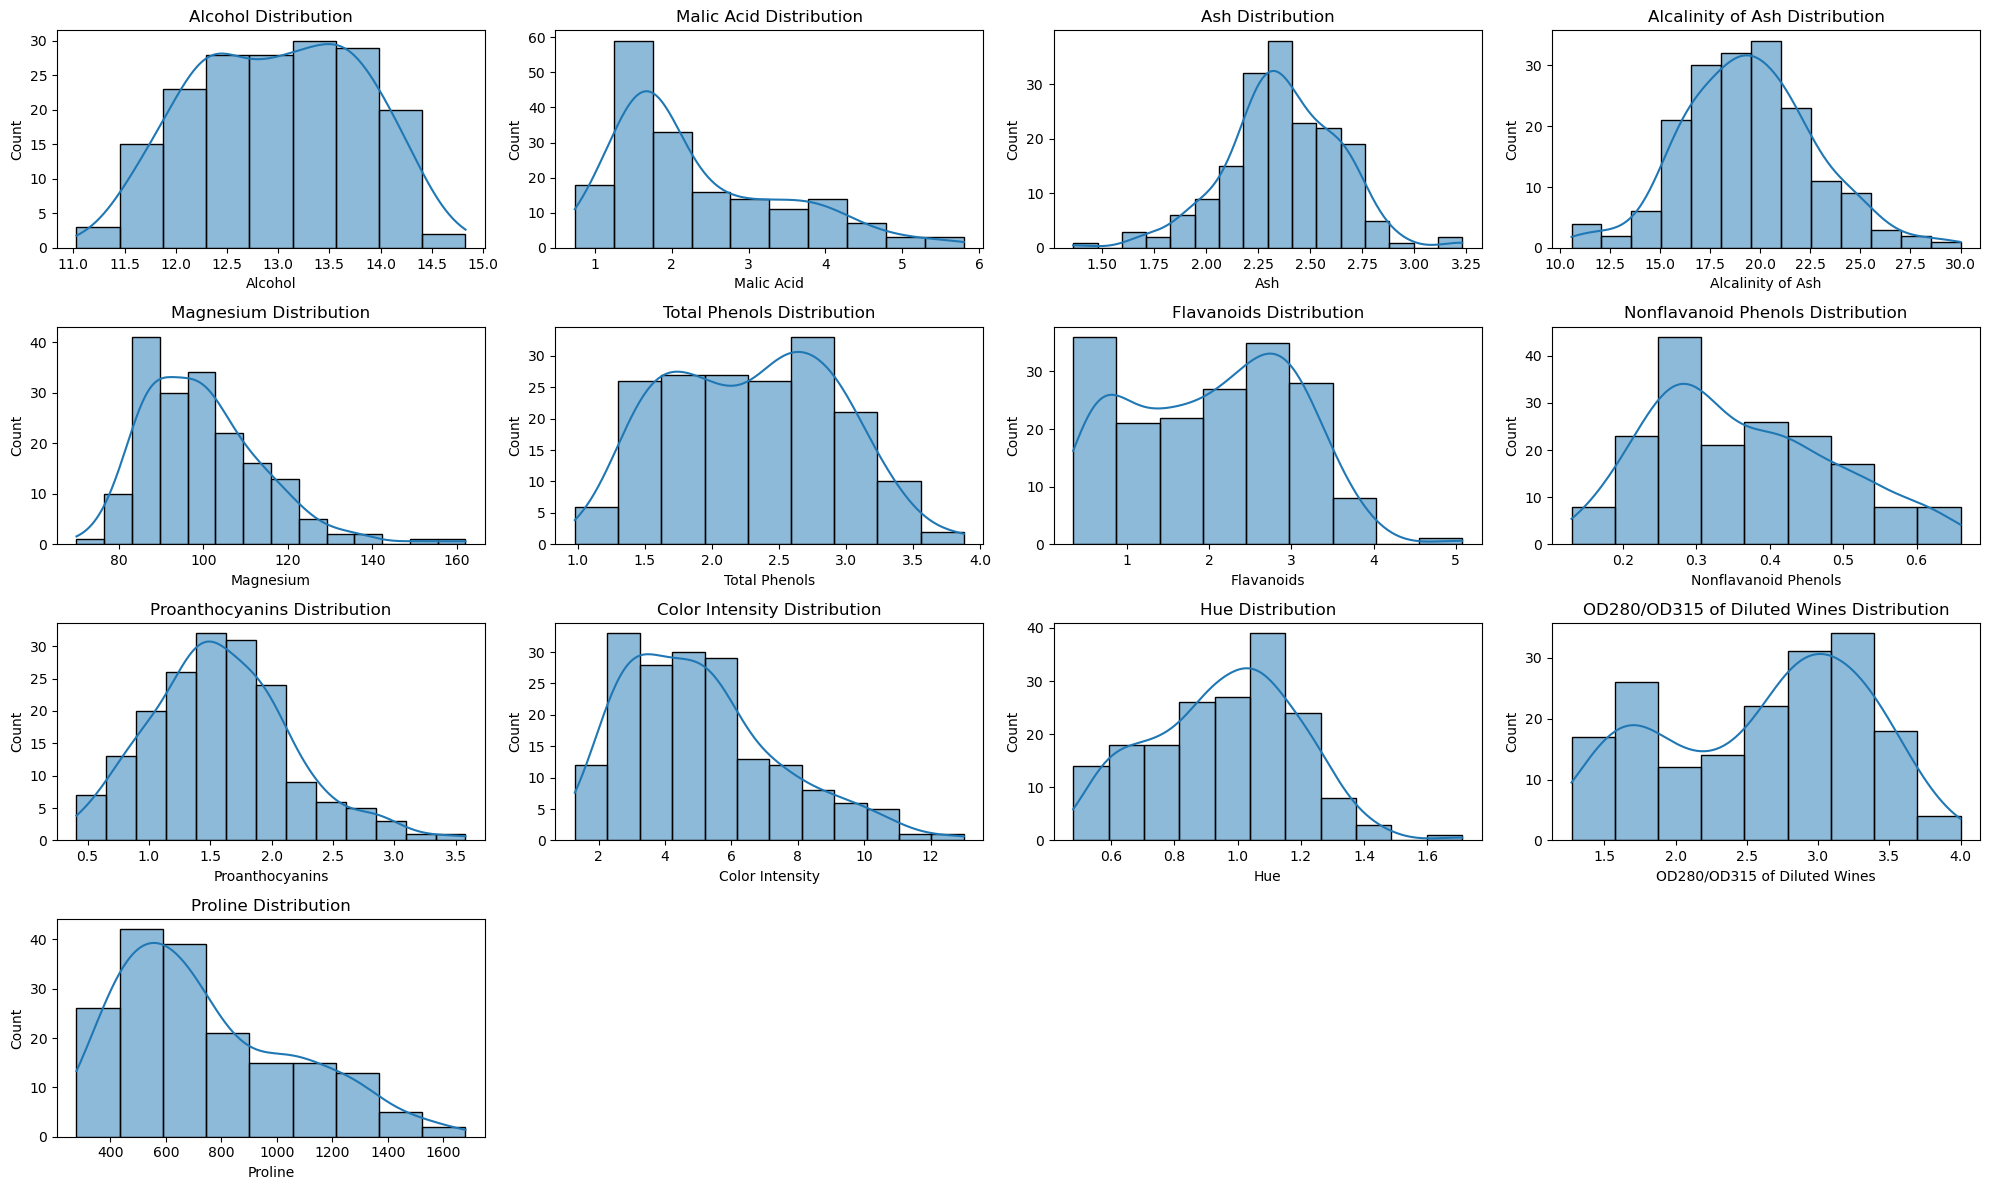

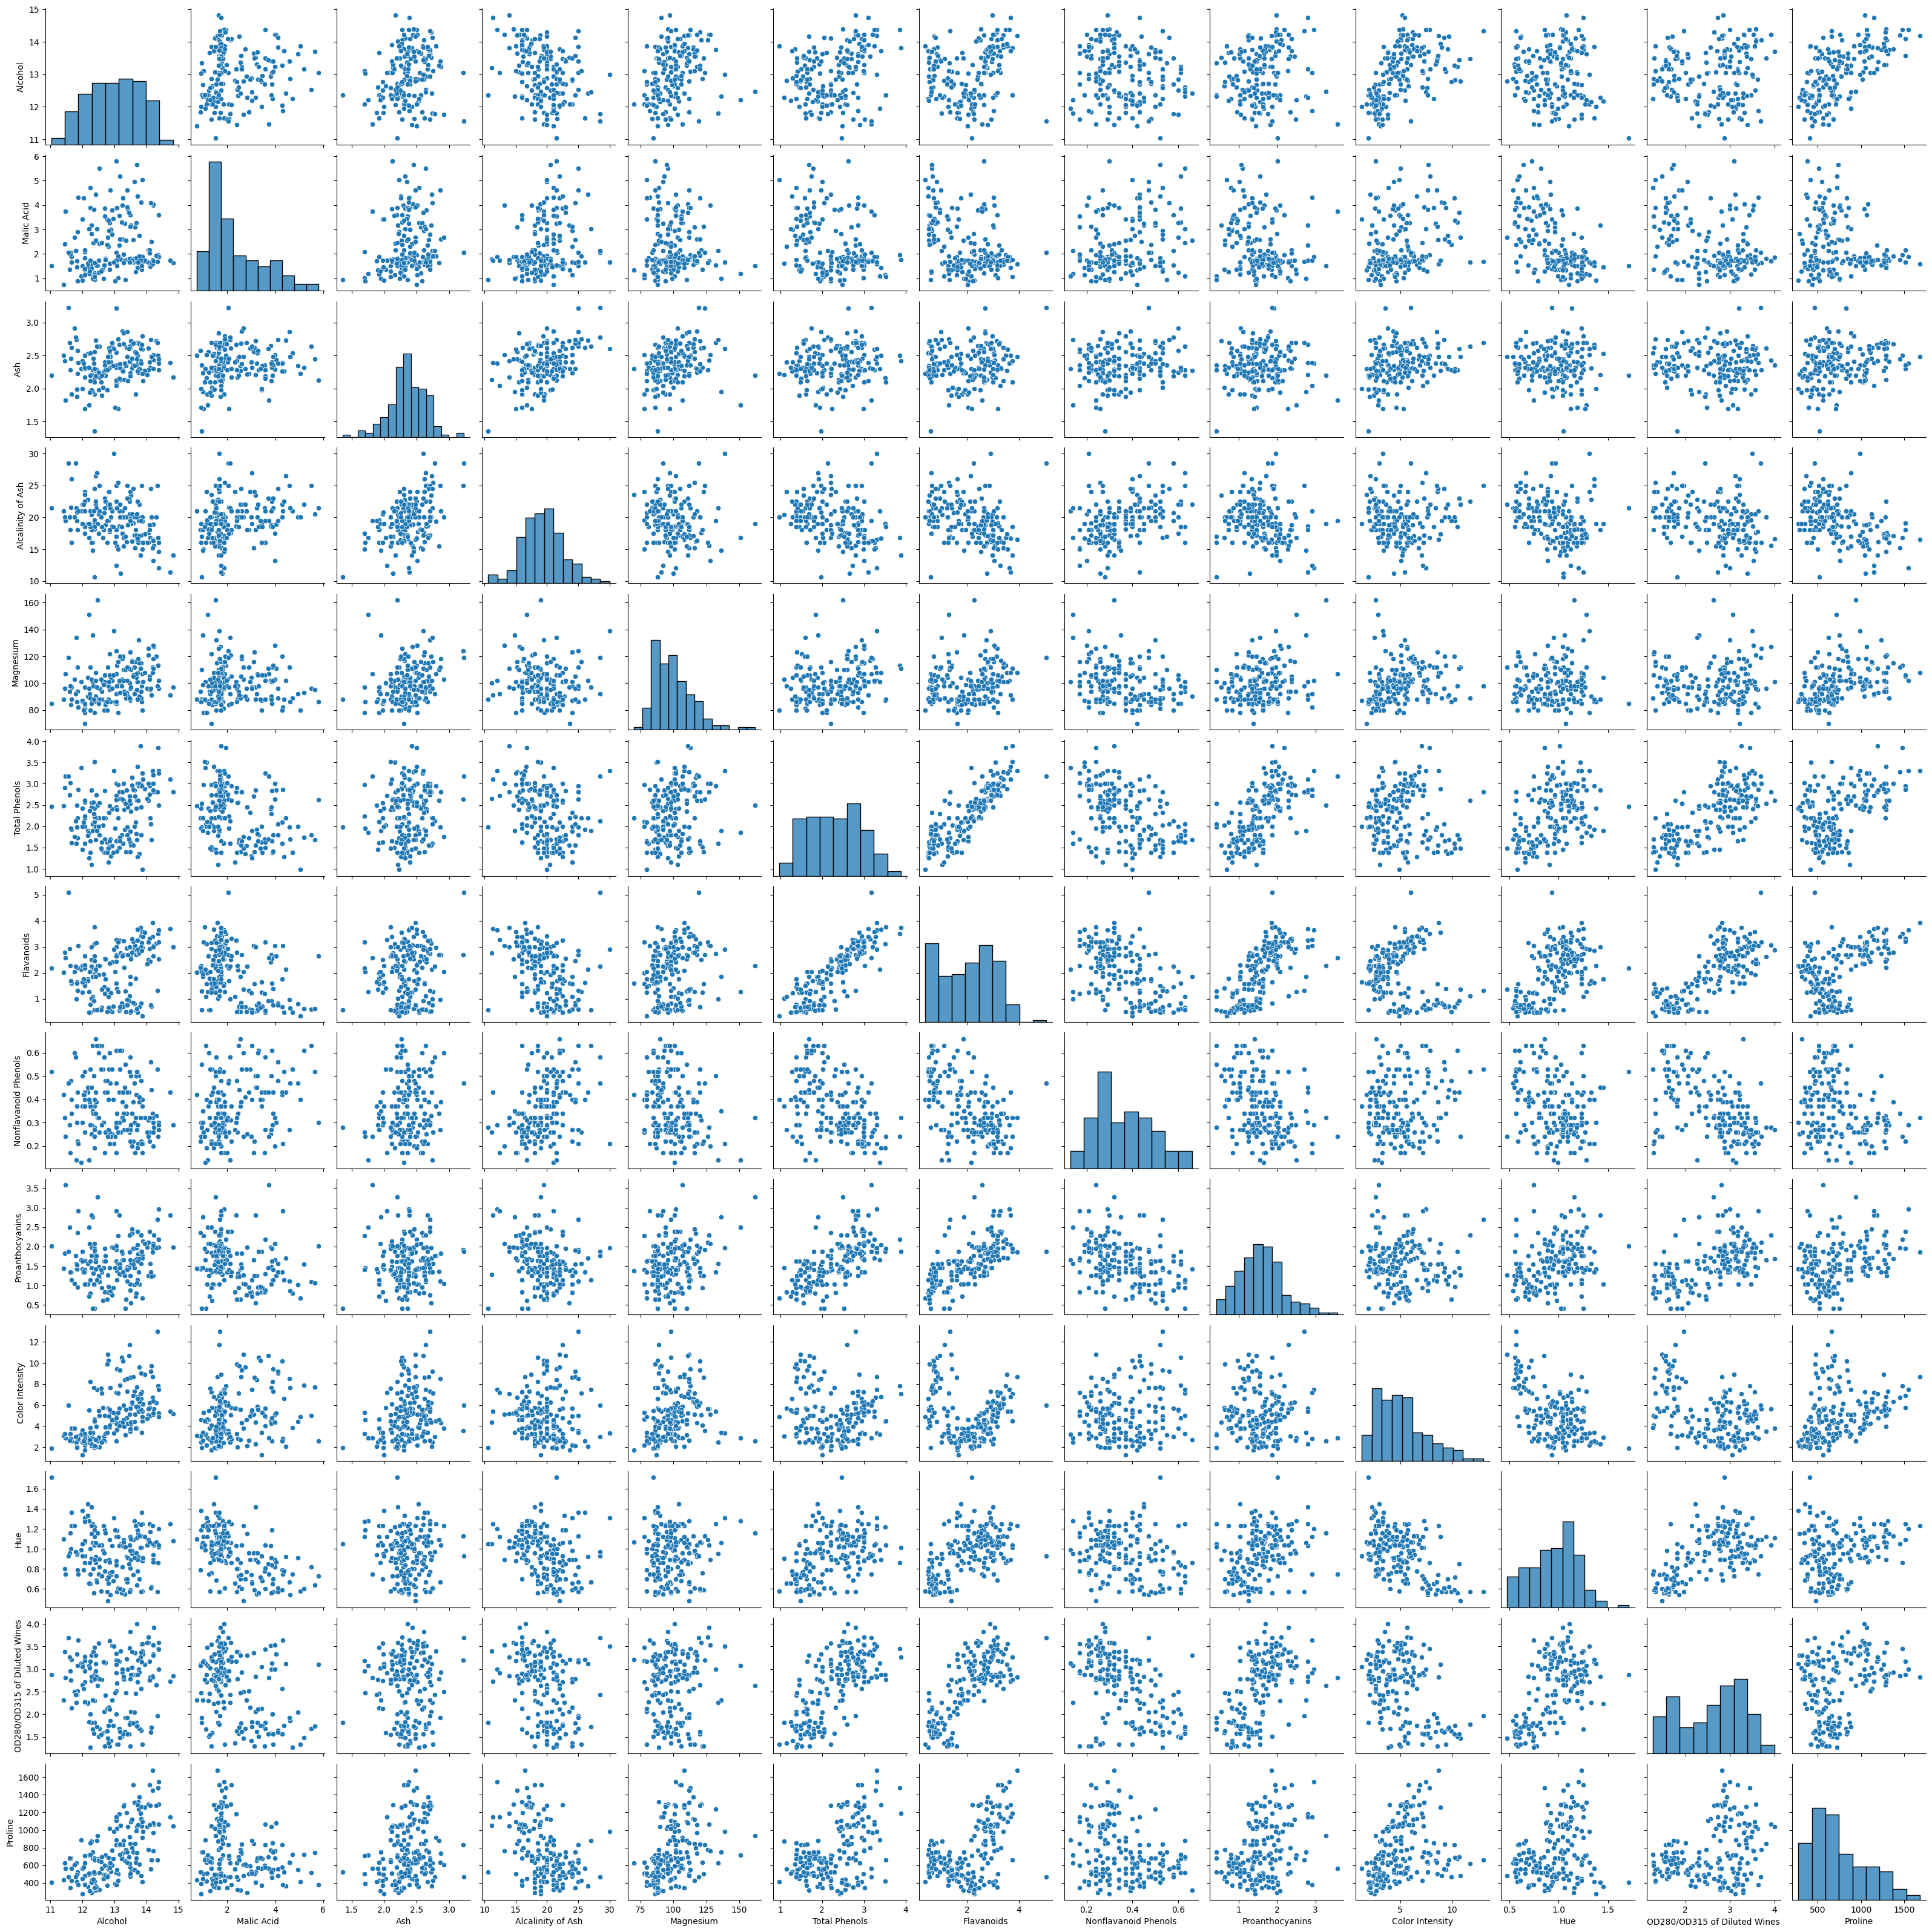

In [6]:
# Summary statistics
df.describe()

# Check for missing values
df.isnull().sum()

# Visualize the distribution of numerical features
plt.figure(figsize=(20, 12))
for i, column in enumerate(columns[1:], 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} Distribution')

plt.tight_layout()
plt.show()

# Visualize the relationship between numerical features
sns.pairplot(df[columns[1:]])
plt.show()


In [7]:
# Standardize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[columns[1:]])

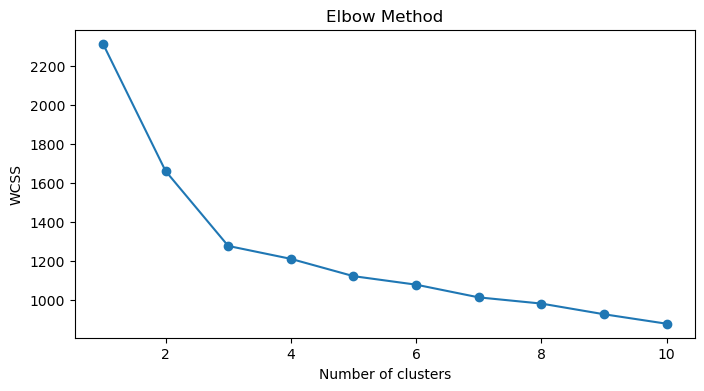

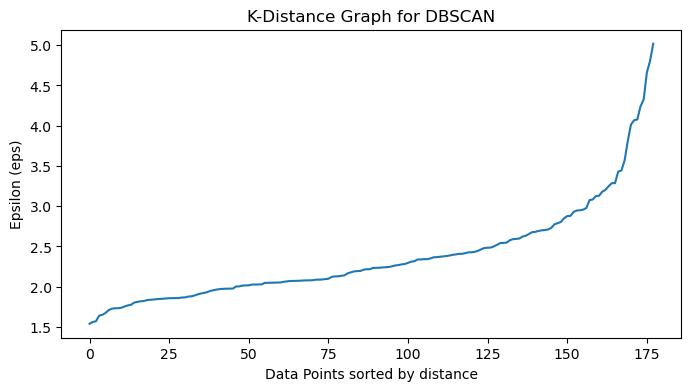

DBSCAN formed 0 clusters
DBSCAN with adjusted parameters formed 0 clusters


In [20]:
# K-Means Clustering
def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    return clusters, kmeans.inertia_

# Agglomerative Clustering
def agglomerative_clustering(data, n_clusters):
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = agglomerative.fit_predict(data)
    return clusters

# DBSCAN Clustering
def dbscan_clustering(data, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    return clusters

# Determine the optimal number of clusters for K-Means and Agglomerative using the elbow method
wcss = []
for i in range(1, 11):
    _, inertia = kmeans_clustering(df_scaled, i)
    wcss.append(inertia)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the optimal number of clusters
kmeans_clusters, _ = kmeans_clustering(df_scaled, 3)

# Apply Agglomerative Clustering with the optimal number of clusters
agglomerative_clusters = agglomerative_clustering(df_scaled, 3)

# Determine the optimal value for eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-Distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon (eps)')
plt.show()

# Based on the graph, choose eps around the elbow point (e.g., 0.6)
dbscan_clusters = dbscan_clustering(df_scaled, eps=0.6, min_samples=5)

# Check number of clusters formed by DBSCAN
n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
print(f"DBSCAN formed {n_clusters_dbscan} clusters")

# If DBSCAN formed valid clusters, proceed; otherwise, adjust parameters
if n_clusters_dbscan > 1:
    dbscan_clusters_tuned = dbscan_clusters
else:
    dbscan_clusters_tuned = dbscan_clustering(df_scaled, eps=0.8, min_samples=5)
    n_clusters_dbscan = len(set(dbscan_clusters_tuned)) - (1 if -1 in dbscan_clusters_tuned else 0)
    print(f"DBSCAN with adjusted parameters formed {n_clusters_dbscan} clusters")

# Add the cluster labels to the original dataframe
df['KMeans_Cluster'] = kmeans_clusters
df['Agglomerative_Cluster'] = agglomerative_clusters
df['DBSCAN_Cluster_Tuned'] = dbscan_clusters_tuned

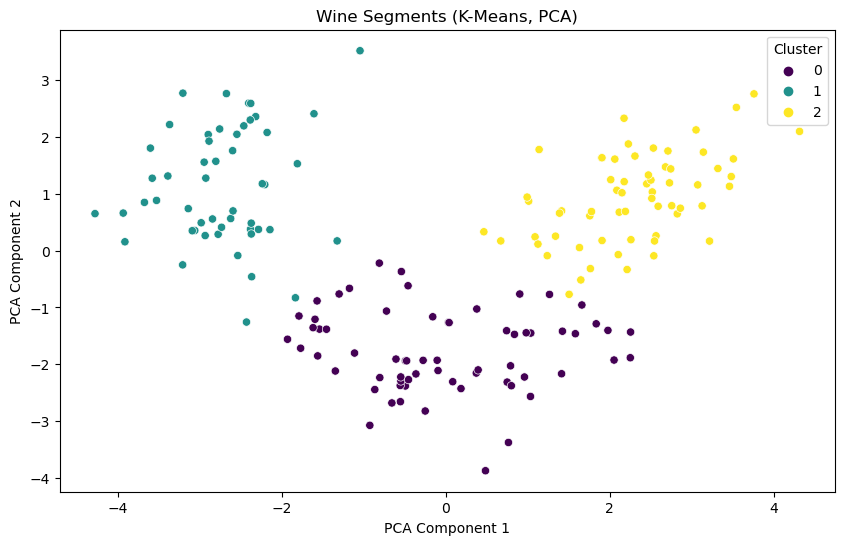

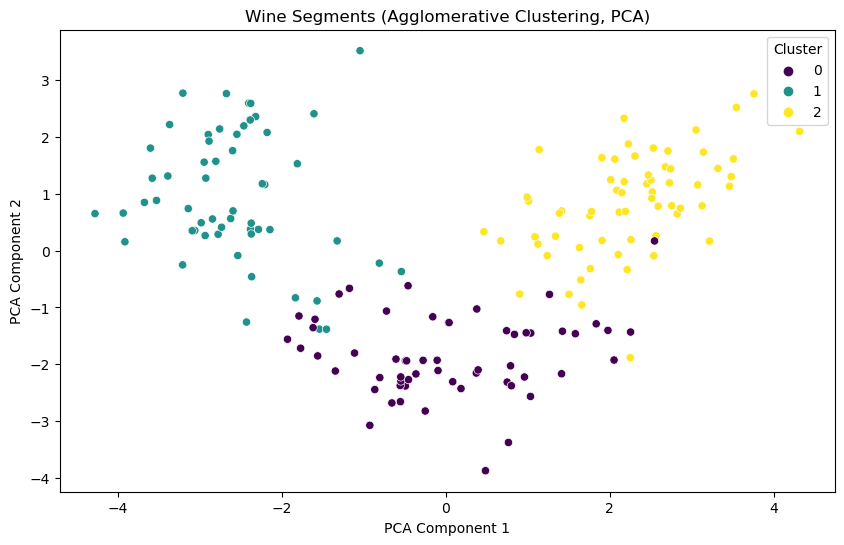

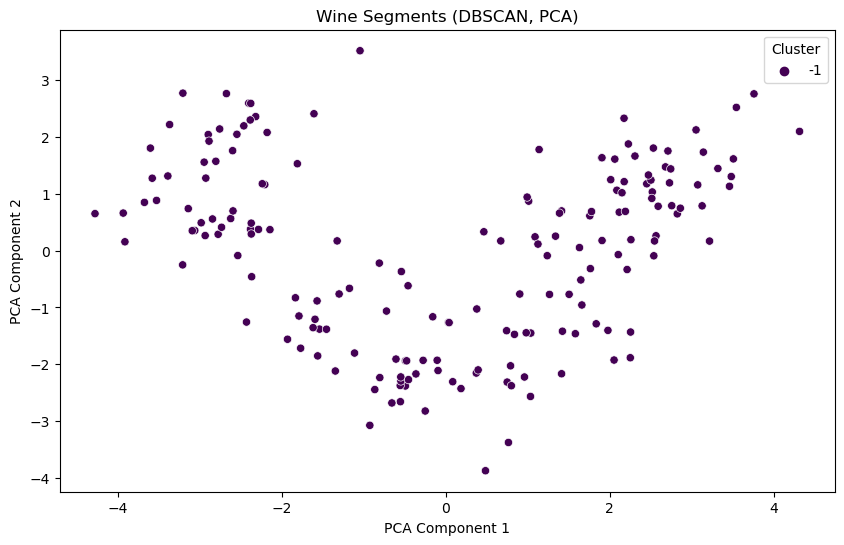

In [21]:
# Visualize the clusters in 2D using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=kmeans_clusters, palette='viridis')
plt.title('Wine Segments (K-Means, PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=agglomerative_clusters, palette='viridis')
plt.title('Wine Segments (Agglomerative Clustering, PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=dbscan_clusters_tuned, palette='viridis')
plt.title('Wine Segments (DBSCAN, PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [24]:
# Evaluate and compare the clustering results using silhouette score and Davies-Bouldin score
kmeans_silhouette = silhouette_score(df_scaled, kmeans_clusters)
agglomerative_silhouette = silhouette_score(df_scaled, agglomerative_clusters)

# Only calculate DBSCAN silhouette score if it has valid clusters
if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(df_scaled, dbscan_clusters_tuned)
else:
    dbscan_silhouette = "Invalid clustering"

kmeans_davies_bouldin = davies_bouldin_score(df_scaled, kmeans_clusters)
agglomerative_davies_bouldin = davies_bouldin_score(df_scaled, agglomerative_clusters)

# Only calculate DBSCAN Davies-Bouldin score if it has valid clusters
if n_clusters_dbscan > 1:
    dbscan_davies_bouldin = davies_bouldin_score(df_scaled, dbscan_clusters_tuned)
else:
    dbscan_davies_bouldin = "Invalid clustering"

print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Agglomerative Clustering Silhouette Score: {agglomerative_silhouette}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

print(f"K-Means Davies-Bouldin Score: {kmeans_davies_bouldin}")
print(f"Agglomerative Clustering Davies-Bouldin Score: {agglomerative_davies_bouldin}")
print(f"DBSCAN Davies-Bouldin Score: {dbscan_davies_bouldin}")


K-Means Silhouette Score: 0.2848589191898987
Agglomerative Clustering Silhouette Score: 0.2774439826952266
DBSCAN Silhouette Score: Invalid clustering
K-Means Davies-Bouldin Score: 1.3891879777181648
Agglomerative Clustering Davies-Bouldin Score: 1.4185919431857326
DBSCAN Davies-Bouldin Score: Invalid clustering
